# Generating toy data and multi-state degradation models from Markov chains: Toy example *ihtmc_s2_typeA*

## Overview
This notebook describes how to generate toy data using continuous-time Markov chains with homogeneous and inhomogeneous time hazard rates. 

In [1]:
# Add to the path
import sys
import os
# Add the indicated folder, and all its subfolders to the path
folder_path = os.path.join(os.path.dirname(os.getcwd()), 'code', 'files', 'scripts')
sys.path.append(folder_path)
for root, dirs, files in os.walk(folder_path):
    for dir in dirs:
        sys.path.append(os.path.join(root, dir))

In [2]:
# Load necessary libraries
from ihtmc import InhomogeneousTimeMarkovChain as IHTMC
from markov_chain_calibration import MarkovChainCalibration as MCCal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from mpl_toolkits.mplot3d import Axes3D
import random

In [3]:
# Define auxiliary functions
def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))
def generate_random_samples(n, bounds):
    return np.random.uniform(low=[b[0] for b in bounds], high=[b[1] for b in bounds], size=(n, len(bounds)))

## Input parameters



In [4]:
#%% Input parameters:
t_from = 0
t_to   = 50
MCStructureID = 'ihtmc_s2_typeA'

In [5]:
#%% Ground-truth Markov chain
ground_hazard_function = 'gompertz'
ground_truth_MC = IHTMC(MCStructureID=MCStructureID,hazard_function=ground_hazard_function)
ground_truth_MC.MCObj.x  = np.array([0.05,0.1])
ground_truth_MC.MCObj.s0 = np.array([0.9,0.1])
g = ground_truth_MC.predict(t=np.linspace(t_from,t_to,1000),atol=1e-4, rtol=1e-4)  # Removed colon at the end

Text(0, 0.5, 'State Probability')

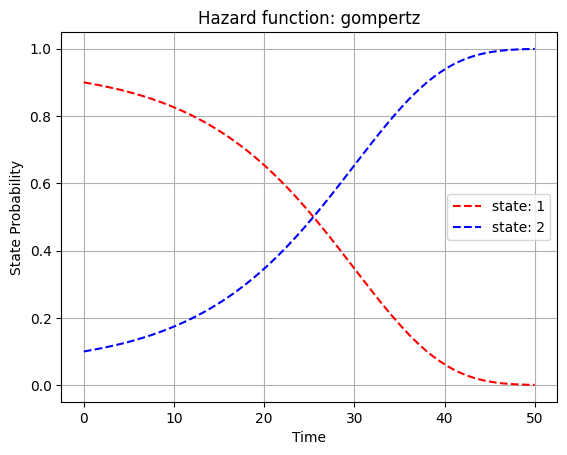

In [6]:
# Plot Ground-truth Markov chain
t = np.linspace(t_from,t_to,1000)
plt.plot(t,ground_truth_MC.predict(t=t)[ground_truth_MC.MCObj.states[0]],color='red',linestyle='--',label='state: '+str(ground_truth_MC.MCObj.states[0]))
plt.plot(t,ground_truth_MC.predict(t=t)[ground_truth_MC.MCObj.states[1]],color='blue',linestyle='--',label='state: '+str(ground_truth_MC.MCObj.states[1]))
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.title('Hazard function: '+ground_hazard_function)
plt.ylabel('State Probability')

In [7]:
#%% Randomly sample from Markov chain --> Generate synthetic dataset.
num_inspections = 10000
ti = np.array(g.index)
s = g.columns
times = np.random.randint(t_from, t_to + 1, num_inspections)#np.random.uniform(t_from, t_to, num_inspections)
choices = [np.random.choice(s, p=g.iloc[np.argmin(np.abs(t - ti))].values) for t in times]
obs = np.column_stack((times, choices))
system_inspections = pd.DataFrame(obs, columns=['time', 'state']).sort_values(by='time', ascending=True).reset_index(drop=True)
system_inspections = system_inspections.groupby(['time', 'state']).size().reset_index(name='count')
system_inspections.set_index('time', inplace=True)
print(system_inspections)

      state  count
time              
0         1    167
0         2     20
1         1    193
1         2     22
2         1    177
...     ...    ...
47        2    212
48        1      1
48        2    216
49        2    229
50        2    197

[98 rows x 2 columns]


Text(0, 0.5, 'Counts')

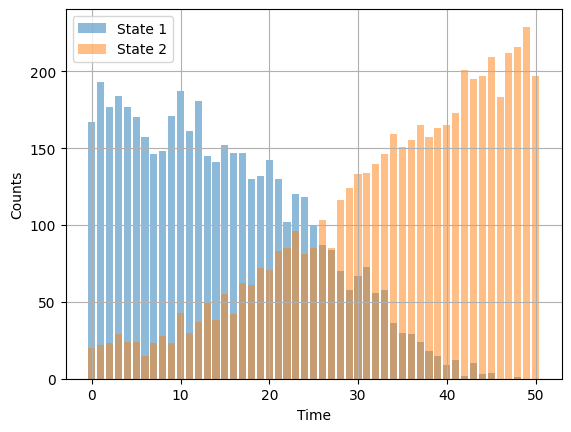

In [9]:
plt.figure()
t = np.linspace(t_from,t_to,1000)
for s in ground_truth_MC.MCObj.states:
    plt.bar(system_inspections[system_inspections['state'] == s].index,
            system_inspections[system_inspections['state'] == s]['count'],
            alpha=0.5,label='State '+str(s))
plt.xlabel('Time')
plt.legend(loc='best')
plt.grid()
plt.ylabel('Counts')

## Train Markov chain models

In [11]:
# Define the hazard function for the Markov models
functions = ['lognormal','loglogistic','gompertz','exponential','weibull']
# Path where models will be stored
path = '../code/files/toy_degradation_models/toy_models_ihtmc_s2_typeA'

In [12]:
#%% Markov chains models:
models = {}
for pdf in functions:
    models[pdf] = IHTMC(df=system_inspections,MCStructureID=MCStructureID,hazard_function=pdf)
    if os.path.exists(path+'/'+pdf+'.dill'):
        models[pdf] = models[pdf].load(filename=pdf,path=path)
    else:
        models[pdf].fit(opt_method='differential_evolution',args={'maxiter':1000,'popsize':50,'polish':True})
        models[pdf].save(filename=pdf,path=path)

## Display Markov chain predictions

/Users/lisandro/Library/CloudStorage/OneDrive-UniversiteitTwente/PhD/Papers/p06b_CMDP/code/files/scripts/aux_files/probability_density_functions.py:45: RuntimeWarning: divide by zero encountered in log
  log_transform = np.log(t / alpha) * beta
/Users/lisandro/Library/CloudStorage/OneDrive-UniversiteitTwente/PhD/Papers/p06b_CMDP/code/files/scripts/aux_files/probability_density_functions.py:45: RuntimeWarning: divide by zero encountered in log
  log_transform = np.log(t / alpha) * beta
/Users/lisandro/Library/CloudStorage/OneDrive-UniversiteitTwente/PhD/Papers/p06b_CMDP/code/files/scripts/aux_files/probability_density_functions.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  return (alpha / beta) * (t / beta)**(alpha - 1)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.5005005005005D-01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1001001001001D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.1001001001001D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in

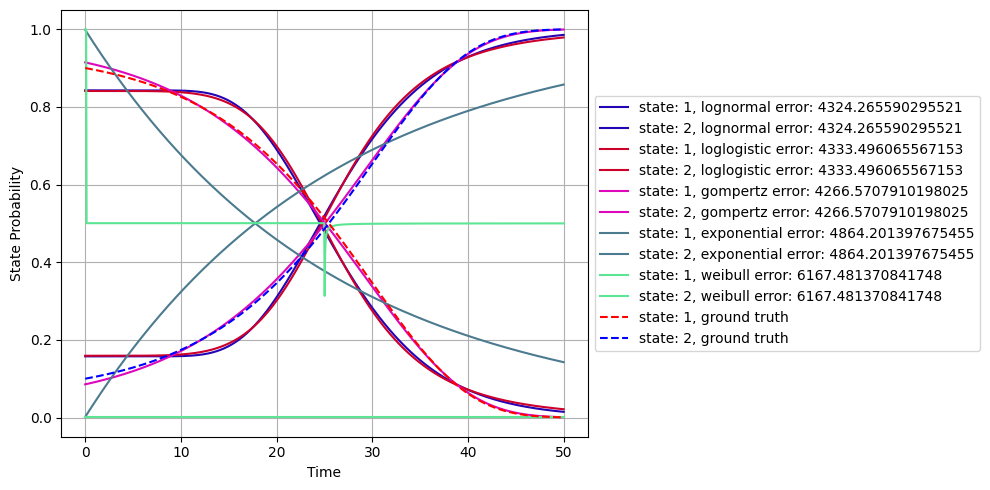

In [13]:
#%% Plot multi-state degradation models:
t = np.linspace(t_from, t_to, 1000)
plt.figure(figsize=(10,5))
for pdf, model in models.items():
    color = random_color()
    for state in model.MCObj.states:
        plt.plot(t, model.predict(t=t)[state], linestyle='-', label=f'state: {state}, {pdf} error: {models[pdf].MCObj.convergence_info["fun"]}', color=color)
for state in ground_truth_MC.MCObj.states:
    plt.plot(t, ground_truth_MC.predict(t=t)[state], linestyle='--', label=f'state: {state}, ground truth', color='red' if state == ground_truth_MC.MCObj.states[0] else 'blue')
plt.xlabel('Time')
plt.ylabel('State Probability')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Visualization of transition probability matrix for inhomogeneous-time Markov chains

### Background

Now that we have trained the multi-state degradation models using inhomogeneous/homogeneous-time Markov chains, we can also plot the value of the transition probability $P_{i,j}(t,\tau)$, between time $t$ and $\tau$. For this, we need to solve the differential equation:

\begin{equation}
\frac{\partial P_{ij}(t,\tau)}{\partial t} = \sum_{k \in S} P_{ik}(t,\tau)Q_{kj}(t)
\end{equation}

Where $P_{ij}(t, \tau): \Omega \times \Omega \to [0,1]$ is a continuous and differentiable function known as the *transition probability matrix*, indicating the probability of transitioning from state $i$ to state $j$ in the time interval $t$ to $\tau$, where $\tau > t$.

### Example
We now demonstrate the computation of the transision probability matrix $P_{i,j}(t,\tau)$ for the **gompertz** (*inhomogeneous*) and **exponential** (*homogeneous*) distributions.

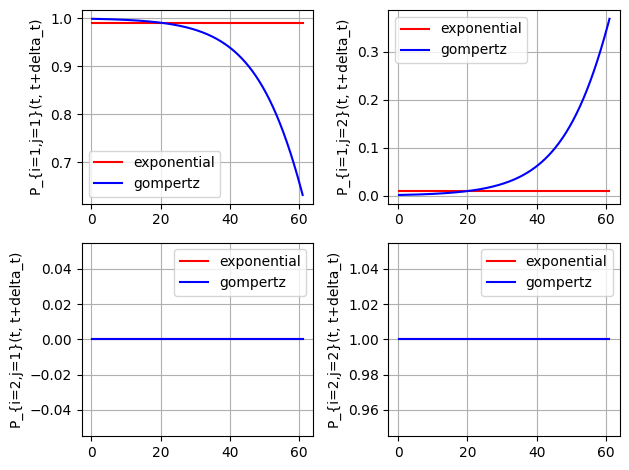

In [14]:
# Get the transition probability matrix per density function.
delta_t = .25 # --> small time step
t       = np.arange(0,61+delta_t,delta_t)
Pij     = {'exponential': models['exponential'].getTransitionProbabilityMatrix(t=t),
           'gompertz': models['gompertz'].getTransitionProbabilityMatrix(t=t)}

fig, axs = plt.subplots(2, 2)  # Create a 2x2 grid of subplots

# From state 1 to state 1
axs[0, 0].plot(Pij['exponential'].index, Pij['exponential'][(1,1)], color='red', label='exponential')
axs[0, 0].plot(Pij['gompertz'].index, Pij['gompertz'][(1,1)], color='blue', label='gompertz')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 0].set_ylabel('P_{i=1,j=1}(t, t+delta_t)')

# From state 1 to state 2
axs[0, 1].plot(Pij['exponential'].index, Pij['exponential'][(1,2)], color='red', label='exponential')
axs[0, 1].plot(Pij['gompertz'].index, Pij['gompertz'][(1,2)], color='blue', label='gompertz')
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].set_ylabel('P_{i=1,j=2}(t, t+delta_t)')

# From state 2 to state 1
axs[1, 0].plot(Pij['exponential'].index, Pij['exponential'][(2,1)], color='red', label='exponential')
axs[1, 0].plot(Pij['gompertz'].index, Pij['gompertz'][(2,1)], color='blue', label='gompertz')
axs[1, 0].legend()
axs[1, 0].grid()
axs[1, 0].set_ylabel('P_{i=2,j=1}(t, t+delta_t)')

# From state 2 to state 2
axs[1, 1].plot(Pij['exponential'].index, Pij['exponential'][(2,2)], color='red', label='exponential')
axs[1, 1].plot(Pij['gompertz'].index, Pij['gompertz'][(2,2)], color='blue', label='gompertz')
axs[1, 1].legend()
axs[1, 1].grid()
axs[1, 1].set_ylabel('P_{i=2,j=2}(t, t+delta_t)')

plt.tight_layout()
plt.show()

In [15]:
# Exponential distribution
print(Pij['exponential'])


         (1, 1)    (1, 2)  (2, 1)  (2, 2)
0.25   0.990315  0.009685     0.0     1.0
0.50   0.990315  0.009685     0.0     1.0
0.75   0.990315  0.009685     0.0     1.0
1.00   0.990315  0.009685     0.0     1.0
1.25   0.990315  0.009685     0.0     1.0
...         ...       ...     ...     ...
60.00  0.990324  0.009676     0.0     1.0
60.25  0.990324  0.009676     0.0     1.0
60.50  0.990324  0.009676     0.0     1.0
60.75  0.990324  0.009676     0.0     1.0
61.00  0.990324  0.009676     0.0     1.0

[244 rows x 4 columns]


In [16]:
# Exponential distribution
print(Pij['gompertz'])

         (1, 1)    (1, 2)  (2, 1)  (2, 2)
0.25   0.998504  0.001496     0.0     1.0
0.50   0.998468  0.001532     0.0     1.0
0.75   0.998432  0.001568     0.0     1.0
1.00   0.998394  0.001606     0.0     1.0
1.25   0.998356  0.001644     0.0     1.0
...         ...       ...     ...     ...
60.00  0.658354  0.341646     0.0     1.0
60.25  0.651825  0.348175     0.0     1.0
60.50  0.645206  0.354794     0.0     1.0
60.75  0.638498  0.361502     0.0     1.0
61.00  0.631703  0.368297     0.0     1.0

[244 rows x 4 columns]


### State probability over time

In [17]:
# Load the transition probability matrix in their matrix form, for this with set output_format='dictionary'
Pmij = {'exponential': models['exponential'].getTransitionProbabilityMatrix(t=t,output_format='dictionary'),
        'gompertz': models['gompertz'].getTransitionProbabilityMatrix(t=t,output_format='dictionary')}

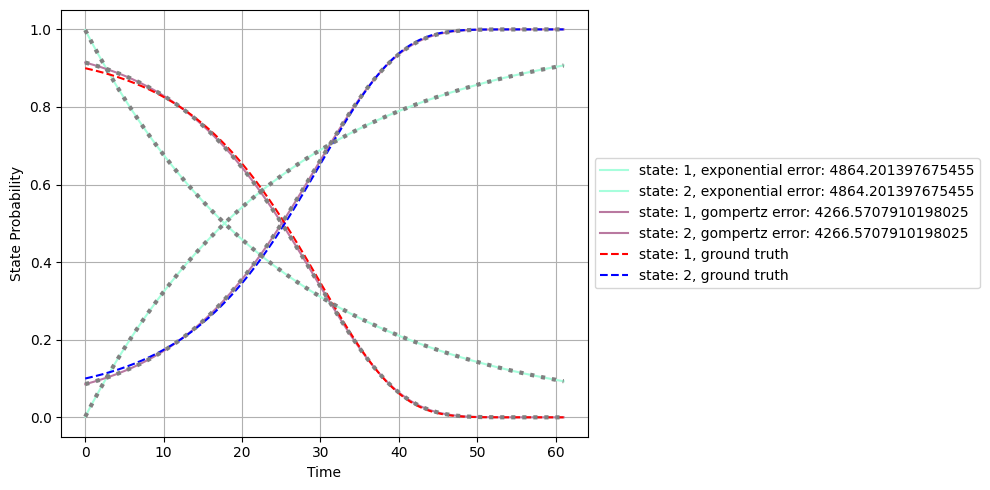

In [18]:
#%% Plot multi-state degradation models:
models = {key: models[key] for key in ['exponential','gompertz']} #--> We use only 'exponential','gompertz'
plt.figure(figsize=(10,5))
for pdf, model in models.items():
    color = random_color()
    for state in model.MCObj.states:
        plt.plot(t, model.predict(t=t)[state], linestyle='-', label=f'state: {state}, {pdf} error: {models[pdf].MCObj.convergence_info["fun"]}', color=color)
for state in ground_truth_MC.MCObj.states:
    plt.plot(t, ground_truth_MC.predict(t=t)[state], linestyle='--', label=f'state: {state}, ground truth', color='red' if state == ground_truth_MC.MCObj.states[0] else 'blue')
    
S = [models['exponential'].MCObj.s0]
for _ in list(Pij['exponential'].index):
    S.append(S[-1].dot(Pmij['exponential'][_]))
S_exponential = np.array(S)
plt.plot(t,S_exponential,color='gray',linestyle=':',linewidth=3)

S = [models['gompertz'].MCObj.s0]
for _ in list(Pij['gompertz'].index):
    S.append(S[-1].dot(Pmij['gompertz'][_]))
S_gompertz = np.array(S)
plt.plot(t,S_gompertz,color='gray',linestyle=':',linewidth=3)
    
    
plt.xlabel('Time')
plt.ylabel('State Probability')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
